In [6]:
import gym
import numpy as np
from keras.models import Sequential
from keras.layers import InputLayer
from keras.layers import Dense
from tqdm import tqdm
from collections import deque
import random


### FrozenLake with Q-Learning

In [80]:
env = gym.make('FrozenLake-v0', is_slippery=False)

discount_factor = 0.95
eps = 0.5
eps_decay_factor = 0.999
learning_rate = 0.8
num_episodes = 10000

In [81]:
#initialize q table
q_table = np.zeros((env.observation_space.n, env.action_space.n))

In [82]:
scores = []
for i in tqdm(range(num_episodes), leave=True, position=0):
    #reset environment
    state = env.reset()
    
    #epsilon greedy decays over time
    #basically more exploration at first then more exploitation
    eps *= eps_decay_factor
    score = 0
    done = False
    
    #run game
    while not done:
        #epsilon greedy
        #exploration given eps or when q table not init
        if np.random.random() < eps or np.sum(q_table[state, :]) == 0:
            action = np.random.randint(0, env.action_space.n)
        else:
            action = np.argmax(q_table[state, :])

        new_state, reward, done, _ = env.step(action)
        score += reward
        q_table[state][action] += learning_rate * (reward + discount_factor * max(q_table[new_state]) - q_table[state][action])
        
        state = new_state
    scores.append(score)

100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:03<00:00, 3022.21it/s]


Building policy:

In [75]:
actions = ['L', 'D', 'R', 'U']
policy = np.zeros([env.observation_space.n], dtype='object')

for i, _ in enumerate(policy):
    policy[i] = actions[np.argmax(q_table[i])]

In [77]:
env.render()

  (Right)
SFFF
FHFH
FFFH
HFFG


In [85]:
np.reshape(policy, (4,4))

array([['D', 'R', 'D', 'L'],
       ['D', 'L', 'D', 'L'],
       ['R', 'D', 'D', 'L'],
       ['L', 'R', 'R', 'L']], dtype=object)

### CartPole-v1 with Deep Q-Learning

In [7]:
env = gym.make('CartPole-v1')
env.reset()

discount_factor = 0.95
eps = 0.5
eps_min = 0.01
eps_decay = 0.99
learning_rate = 0.8
num_episodes = 50
batch_size = 32

Agent playing with random action:

In [ ]:
scores = []
memory = deque(maxlen=2000)

for i in tqdm(range(num_episodes), position=0, leave=True):
    state = env.reset()
    done = False
    score = 0
    #while game not ended
    while not done:
        new_state, reward, done, _ = env.step(env.action_space.sample())
        score += reward
        state = new_state
    scores.append(score)

Agent playing with Deep Q-learning:

In [9]:
model = Sequential()
model.add(Dense(32, input_shape=(4,), activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(2, activation='linear'))
model.compile(loss='mse', optimizer='adam')

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 32)                160       
_________________________________________________________________
dense_5 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 66        
Total params: 1,282
Trainable params: 1,282
Non-trainable params: 0
_________________________________________________________________


In [14]:
scores = []

memory = deque(maxlen=2000)

for i in tqdm(range(num_episodes), position=0, leave=True):
    state = env.reset()
    done = False
    eps *= eps_decay
    score = 0
    #while game not ended
    while not done:
        #choose move with epsilon greedy
        if np.random.random() < eps:
            #exploration
            action = np.random.randint(0, env.action_space.n)
        else:
            #exploitation
            #use expand_dims here to add a dimension for input layer
            q_vals = model.predict(np.expand_dims(state, axis=0))
            action = np.argmax(q_vals)
        
        #execute move
        new_state, reward, done, _ = env.step(action)
        score += reward
        
        #modify reward so it scales with pole angle. Pole angle range [-0.418, 0.418]
        reward = 1 - abs(state[2])/0.418
        
        #memorize
        memory.append([np.expand_dims(state, axis=0), action, reward, np.expand_dims(new_state, axis=0), done])
        
        #update
        #instead of training every state, we train in batch_size
        if len(memory) > batch_size:
            #sample batch_size so model could be fit on any random states in memory not just the latest state
            minibatch = random.sample(memory, batch_size)
            
            #iterate through the sampled batch
            for b_state, b_action, b_reward, b_new_state, b_done in minibatch:
                
                #if current game is done then target = reward cuz theres no future utility
                if b_done:
                    target = b_reward
                else:
                    #what we think the state's q_val should be, reward + discounted future utility
                    target = b_reward + discount_factor * np.max(model.predict(b_new_state))
                
                #what we thought the current state's q_val should be
                target_vector = model.predict(b_state)[0]
                
                #update the target_vector 
                target_vector[b_action] = target
            
                #instead of finding temporal difference between new q_val and old q_val, we train the model by giving it the new q_val
                # and let the network do the updating 
                #train the model with the batch
                model.fit(b_state, target_vector.reshape(-1, env.action_space.n), epochs=1, verbose=0)

            #update epsilon
            if eps > eps_min:
                eps *= eps_decay
                
        #new state
        state = new_state
    scores.append(score)

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [38:13<00:00, 45.87s/it]


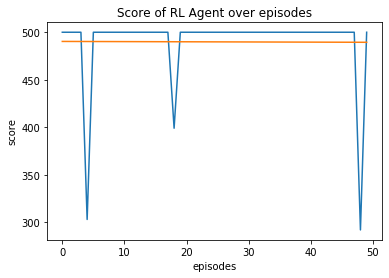

In [18]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

plt.plot(scores)
plt.ylabel('score')
plt.xlabel('episodes')
plt.title('Score of RL Agent over episodes')

reg = LinearRegression().fit(np.arange(len(scores)).reshape(-1, 1), np.array(scores).reshape(-1, 1))
y_pred = reg.predict(np.arange(len(scores)).reshape(-1, 1))
plt.plot(y_pred)


Agent playing with policy:

In [17]:
scores = []
while len(scores) < 50:
    try:
        state = env.reset()
        done = False
        score = 0
        while not done:
            score += 1
#            env.render()
            q_vals = model.predict(np.expand_dims(state, axis=0))
            action = np.argmax(q_vals)

            new_state, _, done, _ = env.step(action)
            state = new_state
        scores.append(score)
    except KeyboardInterrupt:
#        env.close()
        break

In [19]:
np.array(scores).mean()

489.88